In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Interactive widget
from ipywidgets import interact



# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [77]:
url="/content/co2_mm_mlo.csv"
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')
df=pd.read_csv(url,skiprows=72,names=names,index_col=False)
df

year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1960     10     1960.7896   313.83          316.83     -1 -9.99 -0.99
1    1960     11     1960.8743   315.00          316.88     -1 -9.99 -0.99
2    1960     12     1960.9563   316.19          316.96     -1 -9.99 -0.99
3    1961      1     1961.0411   316.89          316.86     -1 -9.99 -0.99
4    1961      2     1961.1260   317.70          317.08     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
756  2023     10     2023.7917   418.82          422.12     27  0.47  0.17
757  2023     11     2023.8750   420.46          422.46     21  0.91  0.38
758  2023     12     2023.9583   421.86          422.58     20  0.68  0.29
759  2024      1     2024.0417   422.80          422.45     27  0.73  0.27
760  2024      2     2024.1250   424.55          423.61     18  1.31  0.59

[761 rows x 8 columns]

In [78]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [79]:
df.head()

year  month  decimal date  average  deseasonalized  ndays  sdev  \
1960-10-01  1960     10     1960.7896   313.83          316.83     -1 -9.99   
1960-11-01  1960     11     1960.8743   315.00          316.88     -1 -9.99   
1960-12-01  1960     12     1960.9563   316.19          316.96     -1 -9.99   
1961-01-01  1961      1     1961.0411   316.89          316.86     -1 -9.99   
1961-02-01  1961      2     1961.1260   317.70          317.08     -1 -9.99   

             unc  
1960-10-01 -0.99  
1960-11-01 -0.99  
1960-12-01 -0.99  
1961-01-01 -0.99  
1961-02-01 -0.99

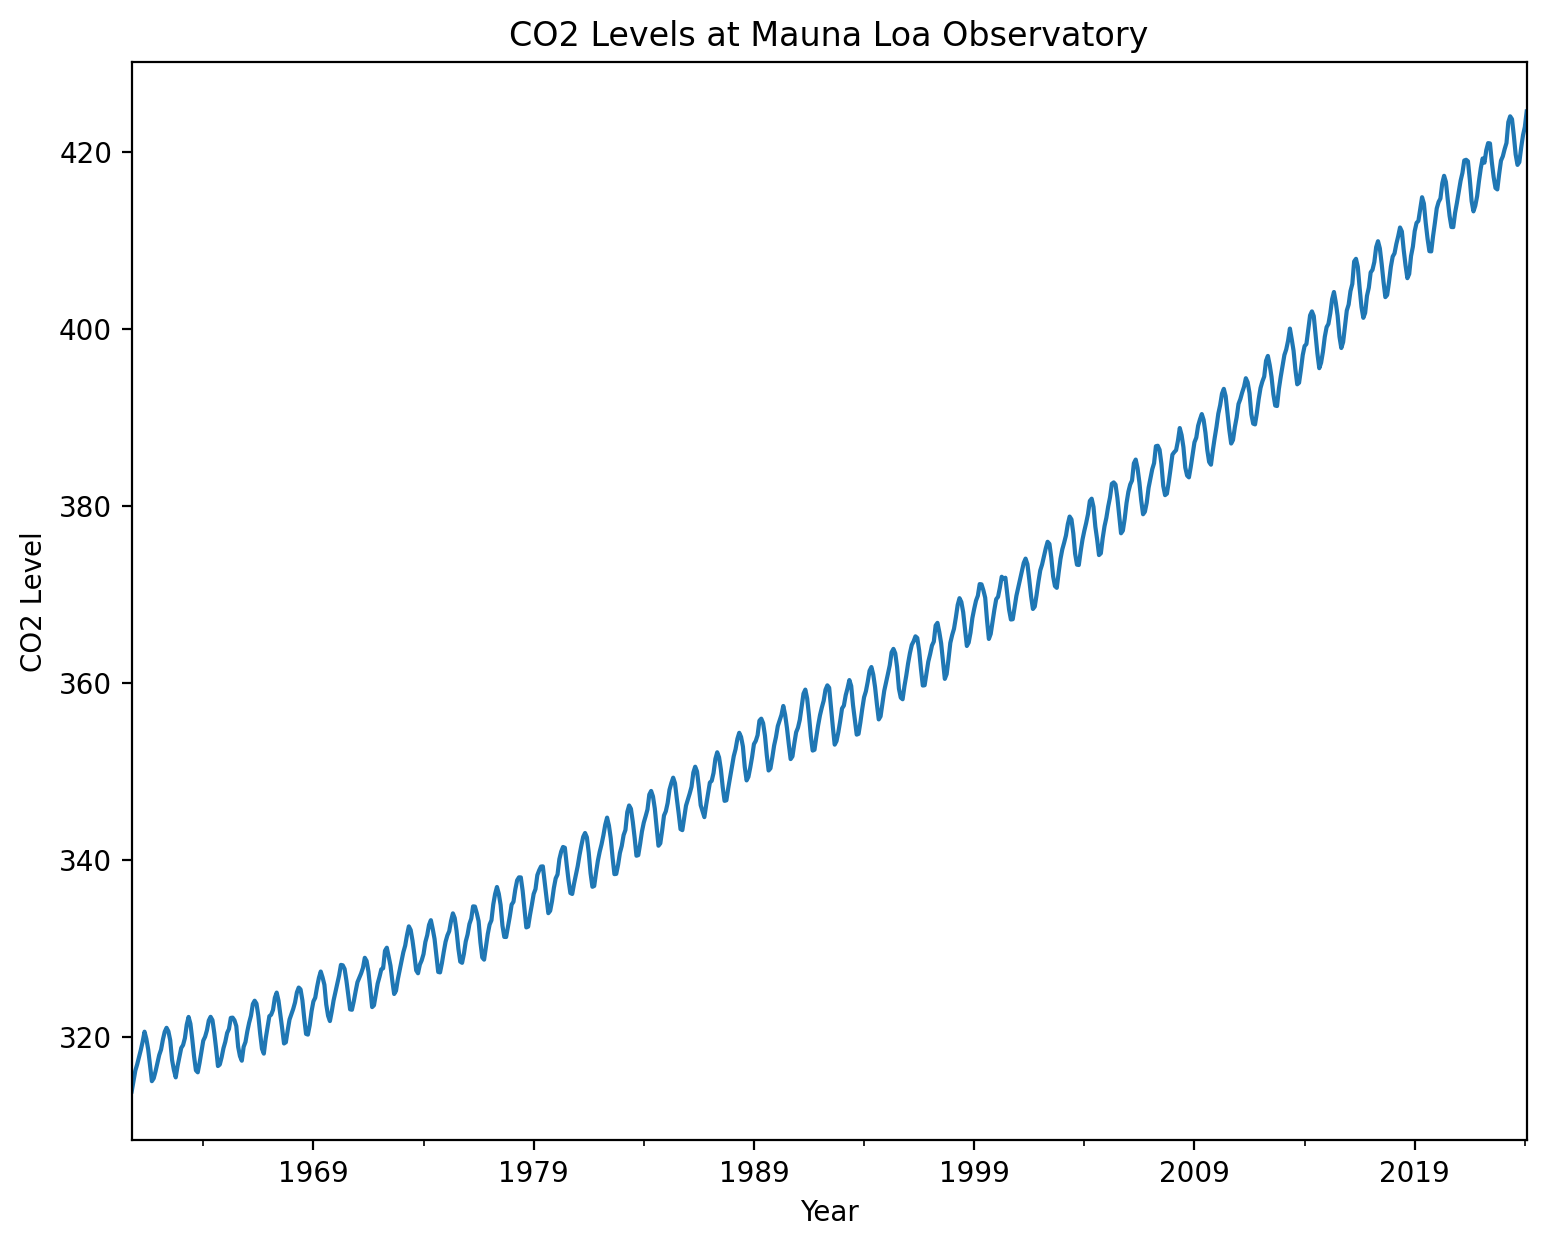

In [80]:
df.average.plot(figsize=(9,7),title="CO2 Levels at Mauna Loa Observatory")
plt.xlabel("Year")
plt.ylabel("CO2 Level")
plt.show()

In [81]:
# Create X and y

# X = months since first measurement
X = np.array(range(len(df)))
y = df.average.values


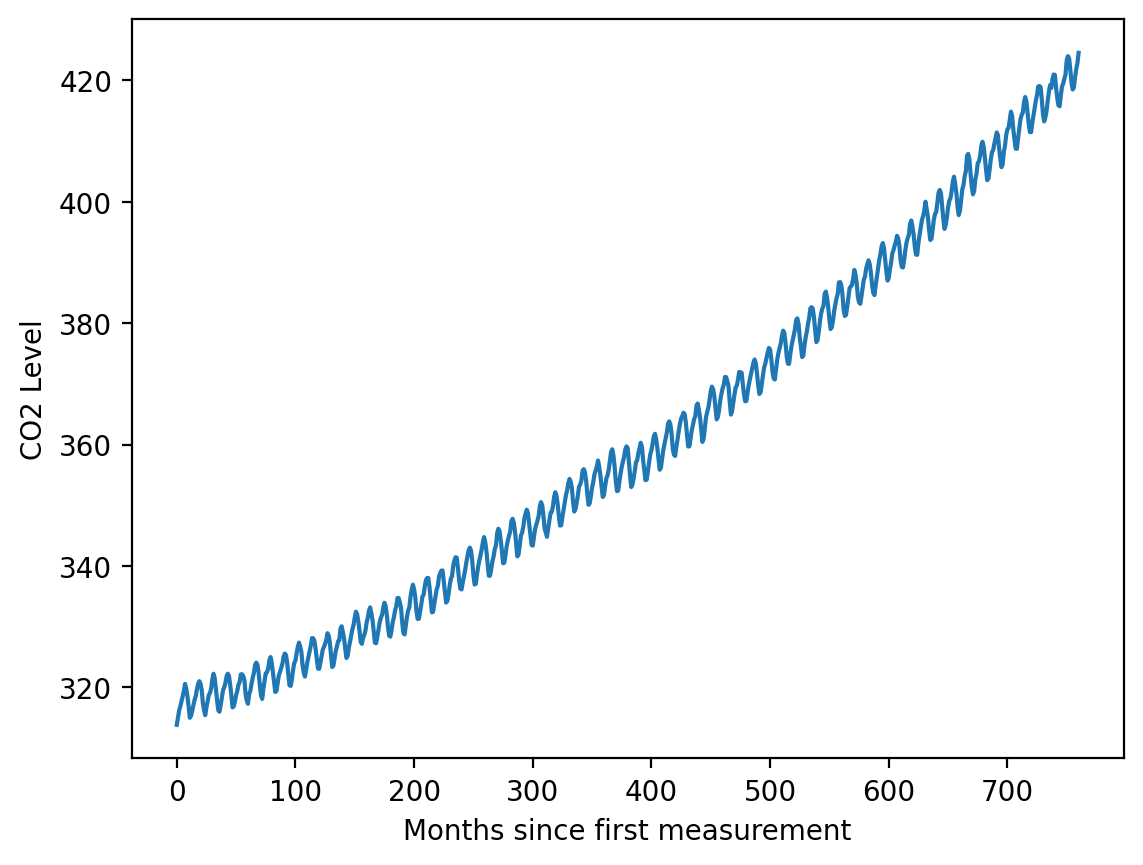

In [82]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')
plt.show()

## Normalise the Dataset

In [83]:
# Normalize X and y

s1 = StandardScaler()
s2 = StandardScaler()

X_norm = s1.fit_transform(X.reshape(-1,1))
y_norm = s2.fit_transform(y.reshape(-1,1))
print(f"Shape of X_norm = {X_norm.shape} and that of y_norm ={y_norm.shape}")

Shape of X_norm = (761, 1) and that of y_norm =(761, 1)


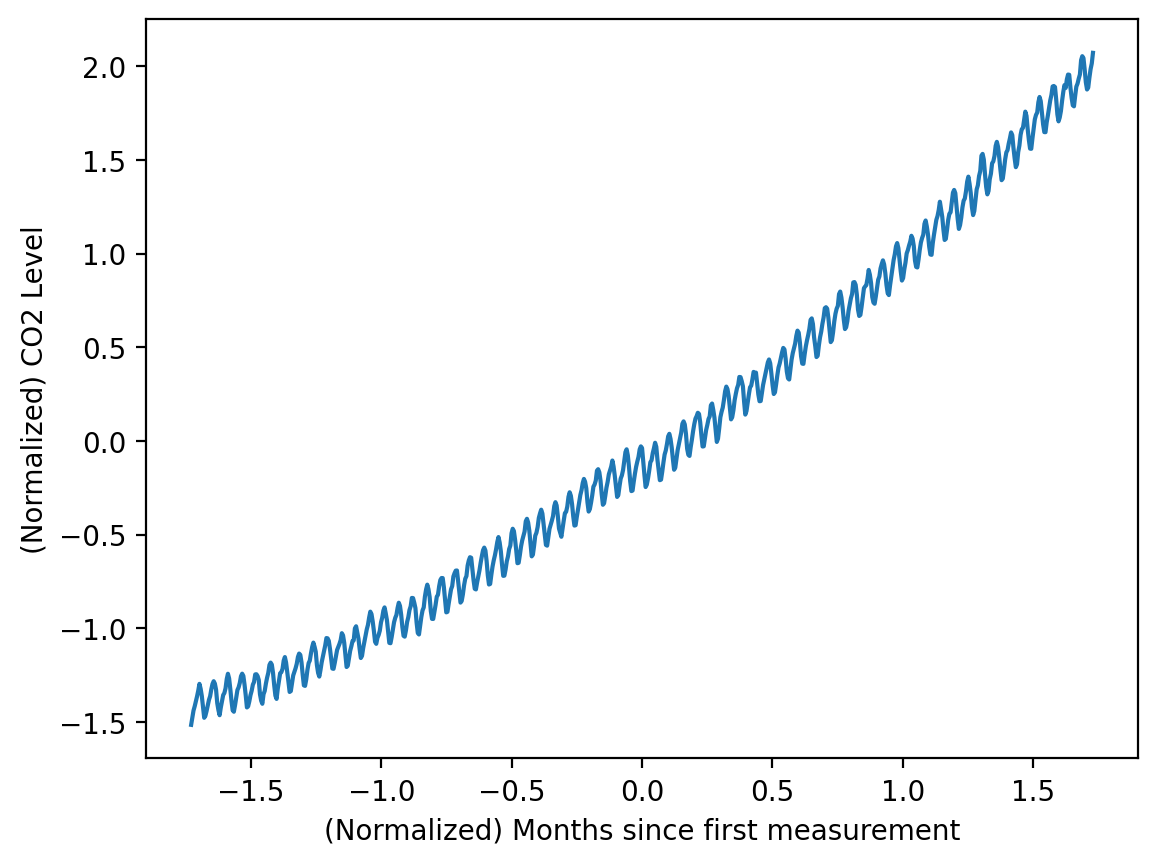

In [84]:
plt.plot(X_norm, y_norm)
plt.xlabel('(Normalized) Months since first measurement')
plt.ylabel('(Normalized) CO2 Level')
plt.show()

# We'll now figure out how to use first K-Months to predict the value of next T months.

In [85]:
def create_data(K,T,y):
 X_data,y_data=[],[]
 for i in range(len(y)-K-T+1):
  X_data.append(y[i:i+K])
  y_data.append(y[i+K:i+K+T])
 X_data=np.array(X_data)
 y_data=np.array(y_data)
 return(X_data,y_data)


### Splitting first 550 samples into train and rest into test.

In [86]:
size=len(X)
size

761

In [87]:

X_train=X[:700]
X_test=X[700:]
y_train=y[:700]
y_test=y[700:]
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
K=10
T=1
print(f"Shape of X_train ={X_train.shape} and shape of y={y_train.shape}")

Shape of X_train =(700,) and shape of y=(700,)


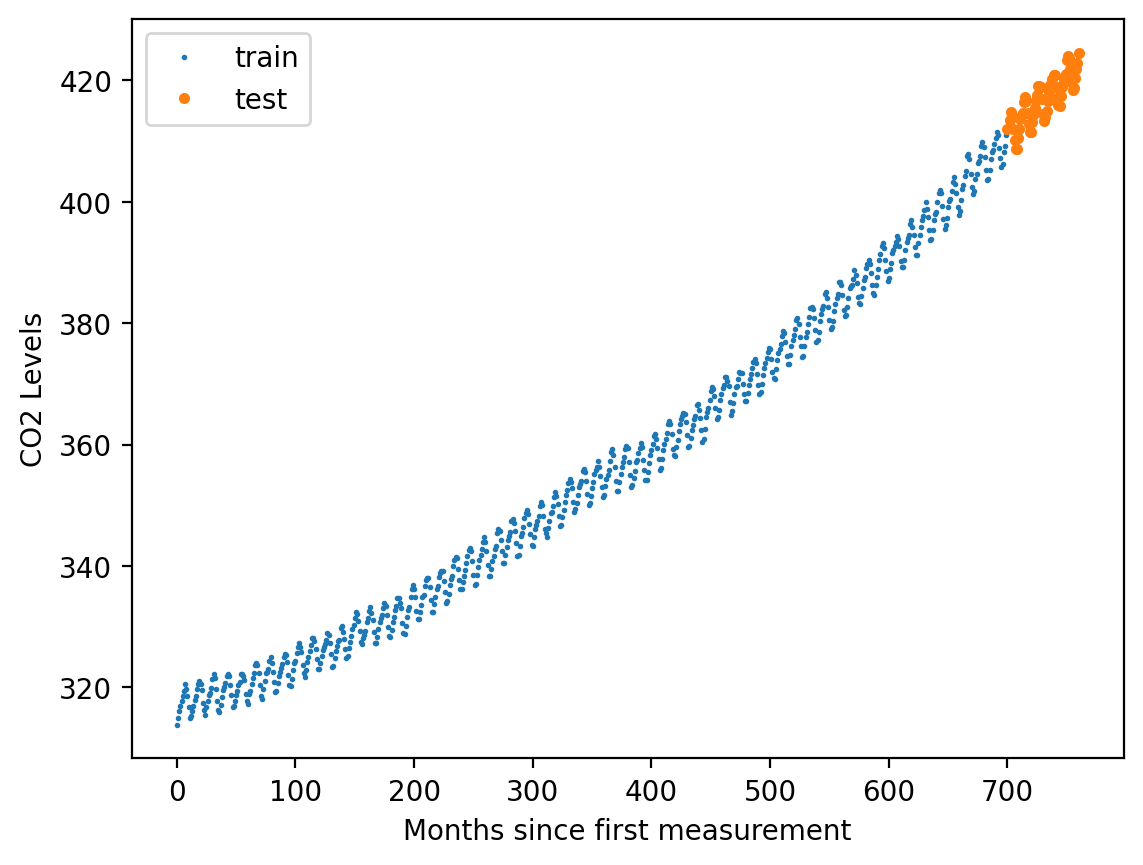

In [88]:
plt.plot(X_train, y_train, 'o', label='train', markersize=1)
plt.plot(X_test, y_test, 'o', label='test', ms=3)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

### Grouping the data

In [89]:
X_train_data,y_train_data=create_data(K,T,y_train)
X_train_data_tensor=torch.tensor(X_train_data,dtype=torch.float32)
y_train_data_tensor=torch.tensor(y_train_data,dtype=torch.float32)
print(f"Size of X_train_data_tensor= {X_train_data_tensor.shape} and that of y_train_data_tensor={y_train_data_tensor.shape}")

Size of X_train_data_tensor= torch.Size([690, 10]) and that of y_train_data_tensor=torch.Size([690, 1])


##Building The Model

In [90]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)# 1st hidden layer
        self.relu = nn.ReLU()# Relu-Activation
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)# 2nd hidden layer
        self.fc3=nn.Linear(hidden_size_2,T)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)
        return out

input_size=X_train_data_tensor.shape[1]
hidden_size_1=64
hidden_size_2=32
hidden_size_3=32


model=NeuralNet(input_size,hidden_size_1)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [91]:
## Train the model

size = 690
batch = 10

# Training loop
for epoch in range(200):
    # Forward pass
    for i in range(size//batch):
      outputs = model(X_train_data_tensor.reshape((690,10))[i:i+batch])

      # Compute the loss
      loss = criterion(outputs, y_train_data_tensor[i:i+batch])

      # Zero the gradients
      optimizer.zero_grad()

      # Backward pass
      loss.backward()

      # Update the weights
      optimizer.step()

    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 19.588537216186523
Epoch 10, Loss: 8.156877517700195
Epoch 20, Loss: 9.6948823928833
Epoch 30, Loss: 15.465766906738281
Epoch 40, Loss: 7.107125282287598
Epoch 50, Loss: 6.774482727050781
Epoch 60, Loss: 6.640453338623047
Epoch 70, Loss: 6.3820390701293945
Epoch 80, Loss: 4.668700218200684
Epoch 90, Loss: 3.8402600288391113
Epoch 100, Loss: 2.654956340789795
Epoch 110, Loss: 1.67031729221344
Epoch 120, Loss: 1.1360023021697998
Epoch 130, Loss: 0.8568121790885925
Epoch 140, Loss: 0.717270016670227
Epoch 150, Loss: 0.6424366235733032
Epoch 160, Loss: 0.5983497500419617
Epoch 170, Loss: 0.5678724050521851
Epoch 180, Loss: 0.5442579984664917
Epoch 190, Loss: 0.5245896577835083


## Testing the Model

In [92]:
X_test_data,y_test_data=create_data(K,T,y_test)
X_test_data_tensor=torch.tensor(X_test_data,dtype=torch.float32)
y_test_data_tensor=torch.tensor(y_test_data,dtype=torch.float32)
y_test_data_tensor.shape

torch.Size([51, 1])

## Forecasting

### Performing on a dummy function

In [93]:
def forecast(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values

  for i in range(0,len(y)-K-T+1,T):
    #print(y[i:i+k])
    input=output_values[i:i+k]# Taking k-sized arrays from the predictions
    print(f"input= {input}")
    T_pred=model(input)# Training it on the k-sized arrays
    output_values=torch.cat((output_values,T_pred),dim=0)# Appending the first prediction
    print(f"output= {output_values}")
  return(output_values)


y_dummy=np.arange(1,11,1)

forecast(model,y_dummy,K,T)

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

### Performing on the actual dataset

In [94]:
def forecast_1(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values
  with torch.no_grad():
    for i in range(0,len(y)-K-T+1,T):

      input=output_values[i:i+k]# Taking k-sized arrays from the predictions
      T_pred=model(input)# Training it on the k-sized arrays
      output_values=torch.cat((output_values,T_pred),dim=0)# Appending the first prediction
    return(output_values)

def forecast_2(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values
  with torch.no_grad():
    for i in range(0,len(y)-K-T+1):

      input=output_values[i:i+k]# Taking k-sized arrays from the predictions
      T_pred=model(input.reshape((1,10)))[0]
      print(T_pred.shape)# Training it on the k-sized arrays
      output_values=torch.cat((output_values,T_pred[0].unsqueeze(0)),dim=0)# Appending the first prediction
    return(output_values)

y_pred=forecast_2(model,y_test,K,T)
y_pred_np=y_pred.numpy()
y_test[:len(y_pred_np)].shape

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


(61,)

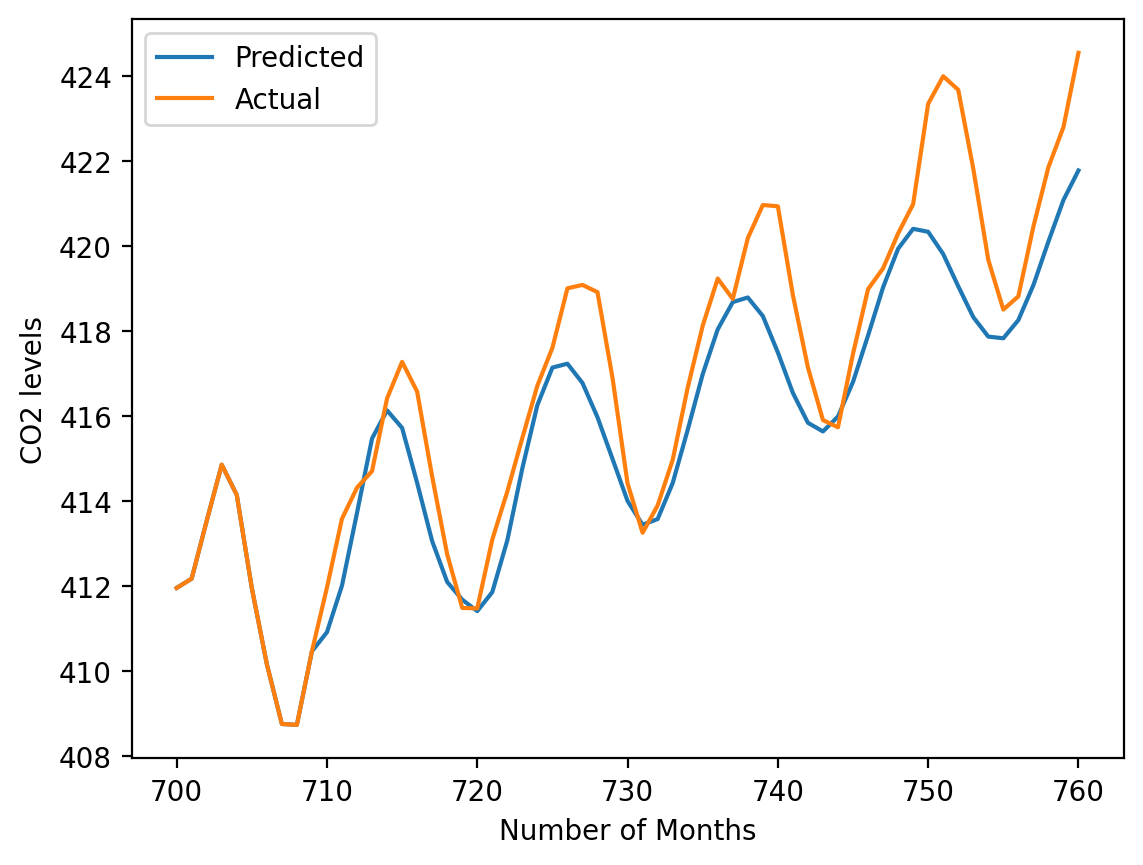

In [95]:
plt.plot(X_test[:len(y_pred_np)],y_pred_np,label="Predicted")
plt.plot(X_test[:len(y_pred_np)],y_test[:len(y_pred_np)],label="Actual")
plt.xlabel("Number of Months")
plt.ylabel("CO2 levels")
plt.legend()
plt.show()
